## Diganose the low lcoud representation in E3SM-MMF and understand the mechanism by model and observation comparison

- mean state analysis 
    - low cloud fraction 
    - radiation flux (ASR, OLR, SWCF, letent heat flux, sensible heat flux)

## Mean state analysis


### Cloud fraction 

In [7]:
import xarray as xr
import datetime
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import numpy as np
from scipy.stats import linregress
from scipy import stats
from itertools import cycle
import cftime
import matplotlib.patches as mpatches



ERA5_PATH = '../data/raw/era5_slp_monthly_ave.nc'
CERES_PATH = '../data/rawCERES_EBAF_Ed4.2_Subset_200003-201910.nc'

MMF_PATH  = '../data/raw/E3SM-MMF_1950-2015_Regrid180x360.nc'
E3SM_PATH = '../data/raw/E3SM_1950-2015_regrid180x360.nc'
MMF_CLDTOT = '../data/raw/mmf_remap_cldtot.nc'
E3SM_CLDTOT = '../data/raw/e3sm_remap_cldtot.nc'

# Define regions with [lon_min, lon_max, lat_min, lat_max] and color
# Convert to 0-360 format
regions = {
    'Australian': {'coords': [95, 105, -35, -25], 'color': 'blue'},  # No change needed (already positive)
    'Californian': {'coords': [230, 240, 20, 30], 'color': 'red'},   # -130 -> 230, -120 -> 240
    'Canarian': {'coords': [325, 335, 15, 25], 'color': 'green'},    # -35 -> 325, -25 -> 335
    'Namibian': {'coords': [0, 10, -20, -10], 'color': 'yellow'},    # No change needed
    'Peruvian': {'coords': [270, 280, -20, -10], 'color': 'purple'}  # -90 -> 270, -80 -> 280
}

In [4]:
# mmf = xr.open_dataset(MMF_PATH)
sim_cf_vars = ['CLDTOT', 'CLDLOW']
era5_cf_vars = ['tcc', 'lcc']
time_slice = slice('2000-01-01', '2014-12-31')

def read_ds(path, vars, timeslice):
    ds = xr.open_dataset(path)
    ds = ds[vars].sel(time=timeslice)
    return ds 

def ds_mean(ds):
    return ds.mean(dim='time')

mmf = xr.open_dataset(MMF_PATH)
lats = mmf.lat.values
lons = mmf.lon.values

In [5]:

mmf_cldlow = read_ds(MMF_PATH, sim_cf_vars[1], time_slice)
e3sm_cldlow = read_ds(E3SM_PATH, sim_cf_vars[1], time_slice)
mmf_cldtot = read_ds(MMF_CLDTOT, sim_cf_vars[0], time_slice)
e3sm_cldtot = read_ds(E3SM_CLDTOT, sim_cf_vars[0], time_slice)
mmf_cf = xr.merge([mmf_cldtot, mmf_cldlow])
e3sm_cf = xr.merge([e3sm_cldtot, e3sm_cldlow])

lons = mmf_cf.lon.values
lats = mmf_cf.lat.values

era5_cf = read_ds(ERA5_PATH, era5_cf_vars, time_slice)
era5_cf= era5_cf.rename({'tcc':'CLDTOT', 'lcc':'CLDLOW'})
era5_cf= era5_cf.rename({'latitude':'lat', 'longitude':'lon'})

era5_cf = era5_cf.sel(expver=1)
era5_cf = era5_cf.sel(lat=lats, lon=lons)
mmf_cf_mean = ds_mean(mmf_cf)
e3sm_cf_mean = ds_mean(e3sm_cf)
era5_cf_mean = ds_mean(era5_cf)


In [8]:
# Calculate and print regional statistics
print("Regional Analysis of Low Cloud Fraction")
print("=" * 50)

for region_name, region_info in regions.items():
    print(f"\n{region_name} Region:")
    print("-" * 30)
    
    # Extract regional data
    mmf_regional = mmf_cf_mean['CLDLOW'].sel(lon=slice(*region_info['coords'][0:2]), 
                                            lat=slice(*region_info['coords'][2:4])).mean().values
    e3sm_regional = e3sm_cf_mean['CLDLOW'].sel(lon=slice(*region_info['coords'][0:2]), 
                                              lat=slice(*region_info['coords'][2:4])).mean().values
    era5_regional = era5_cf_mean['CLDLOW'].sel(lon=slice(*region_info['coords'][0:2]), 
                                              lat=slice(*region_info['coords'][2:4])).mean().values
    
    # Calculate differences
    mmf_diff = mmf_regional - era5_regional
    e3sm_diff = e3sm_regional - era5_regional
    
    print(f"ERA5: {era5_regional:.3f}")
    print(f"E3SM-MMF: {mmf_regional:.3f} (diff: {mmf_diff:.3f})")
    print(f"E3SMv2: {e3sm_regional:.3f} (diff: {e3sm_diff:.3f})")
    print(f"Relative difference MMF: {(mmf_diff/era5_regional)*100:.1f}%")
    print(f"Relative difference E3SMv2: {(e3sm_diff/era5_regional)*100:.1f}%")


Regional Analysis of Low Cloud Fraction

Australian Region:
------------------------------
ERA5: 0.547
E3SM-MMF: 0.519 (diff: -0.028)
E3SMv2: 0.497 (diff: -0.050)
Relative difference MMF: -5.1%
Relative difference E3SMv2: -9.2%

Californian Region:
------------------------------
ERA5: 0.642
E3SM-MMF: 0.404 (diff: -0.239)
E3SMv2: 0.494 (diff: -0.148)
Relative difference MMF: -37.2%
Relative difference E3SMv2: -23.0%

Canarian Region:
------------------------------
ERA5: 0.411
E3SM-MMF: 0.359 (diff: -0.053)
E3SMv2: 0.349 (diff: -0.063)
Relative difference MMF: -12.9%
Relative difference E3SMv2: -15.3%

Namibian Region:
------------------------------
ERA5: 0.614
E3SM-MMF: 0.433 (diff: -0.181)
E3SMv2: 0.543 (diff: -0.071)
Relative difference MMF: -29.5%
Relative difference E3SMv2: -11.5%

Peruvian Region:
------------------------------
ERA5: 0.669
E3SM-MMF: 0.486 (diff: -0.184)
E3SMv2: 0.708 (diff: 0.039)
Relative difference MMF: -27.4%
Relative difference E3SMv2: 5.8%


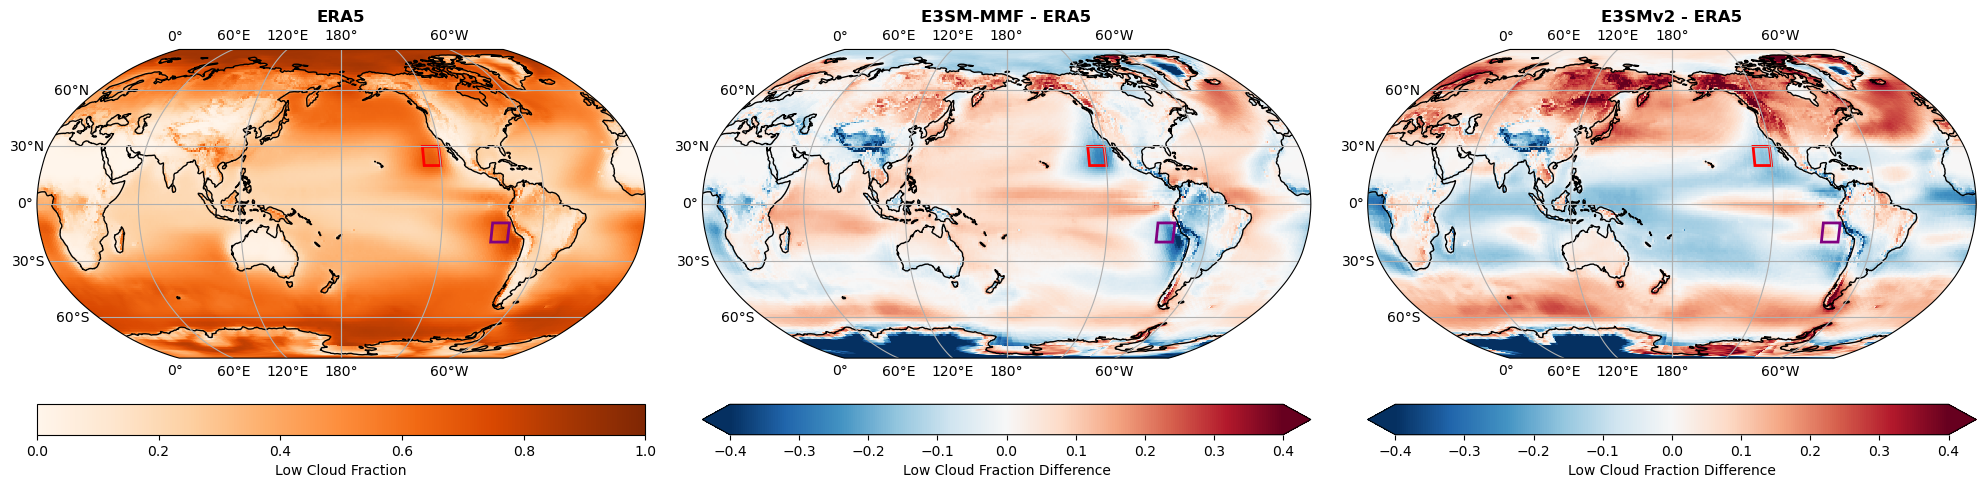

In [15]:
def plot_lowcloud_comparison(era5_cf_mean, mmf_cf_mean, e3sm_cf_mean):
    """
    Plot ERA5 low cloud fraction and differences with E3SM-MMF and E3SMv2 in one row
    Shows only Californian and Peruvian stratocumulus regions
    """
    fig = plt.figure(figsize=(20, 5))
    
    # Create projection
    projection = ccrs.Robinson(central_longitude=180)
    
    # Create subplots in one row
    ax1 = plt.subplot(131, projection=projection)
    ax2 = plt.subplot(132, projection=projection)
    ax3 = plt.subplot(133, projection=projection)
    
    # Set up parameters
    vmin, vmax = 0, 1  # for ERA5 values
    diff_vmin, diff_vmax = -0.4, 0.4  # for differences
    
    # Plot ERA5 (using Oranges colormap)
    im1 = era5_cf_mean['CLDLOW'].plot(ax=ax1, transform=ccrs.PlateCarree(),
                                     cmap='Oranges', vmin=vmin, vmax=vmax,
                                     add_colorbar=True,
                                     cbar_kwargs={'label': 'Low Cloud Fraction',
                                                'orientation': 'horizontal',
                                                'pad': 0.1})
    ax1.set_title('ERA5', fontsize=12, pad=5, weight='bold')
    
    # Plot differences (using RdBu_r colormap)
    # E3SM-MMF - ERA5
    diff_mmf = mmf_cf_mean['CLDLOW'] - era5_cf_mean['CLDLOW']
    im2 = diff_mmf.plot(ax=ax2, transform=ccrs.PlateCarree(),
                       cmap='RdBu_r', vmin=diff_vmin, vmax=diff_vmax,
                       add_colorbar=True,
                       cbar_kwargs={'label': 'Low Cloud Fraction Difference',
                                  'orientation': 'horizontal',
                                  'pad': 0.1})
    ax2.set_title('E3SM-MMF - ERA5', fontsize=12, pad=5, weight='bold')
    
    # E3SMv2 - ERA5
    diff_e3sm = e3sm_cf_mean['CLDLOW'] - era5_cf_mean['CLDLOW']
    im3 = diff_e3sm.plot(ax=ax3, transform=ccrs.PlateCarree(),
                        cmap='RdBu_r', vmin=diff_vmin, vmax=diff_vmax,
                        add_colorbar=True,
                        cbar_kwargs={'label': 'Low Cloud Fraction Difference',
                                   'orientation': 'horizontal',
                                   'pad': 0.1})
    ax3.set_title('E3SMv2 - ERA5', fontsize=12, pad=5, weight='bold')
    
    # Selected regions to show
    selected_regions = ['Californian', 'Peruvian']
    
    # Add features to all subplots
    for ax in [ax1, ax2, ax3]:
        ax.coastlines()
        ax.gridlines(draw_labels=True)
        
        # Add boxes only for Californian and Peruvian regions
        for region_name in selected_regions:
            region_info = regions[region_name]
            lon_min, lon_max, lat_min, lat_max = region_info['coords']
            box = mpatches.Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min,
                                   fill=False, edgecolor=region_info['color'], linewidth=2,
                                   transform=ccrs.PlateCarree())
            ax.add_patch(box)
    
    plt.tight_layout()
    
    return fig

# Create plot
fig = plot_lowcloud_comparison(era5_cf_mean, mmf_cf_mean, e3sm_cf_mean)
plt.show()

## Radiation Flux

In [16]:
ceres = xr.open_dataset(CERES_PATH)


In [17]:
ceres['toa_cre_sw_mon']

<xarray.DataArray 'toa_cre_sw_mon' (time: 236, lat: 180, lon: 360)>
[15292800 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * time     (time) datetime64[ns] 2000-03-15 2000-04-15 ... 2019-10-15
Attributes:
    long_name:      Top of The Atmosphere Cloud Radiative Effects Shortwave F...
    standard_name:  TOA CRE Shortwave Flux
    CF_name:        toa_shortwave_cloud_radiative_effect
    comment:        Calculated as all-sky flux minus clear-sky (for total reg...
    units:          W m-2
    valid_min:           -400.000
    valid_max:            100.000

In [19]:
# Define time slice
time_slice = slice('2000-01-01', '2014-12-31')

# Read and process data with time selection
ceres = xr.open_dataset(CERES_PATH).sel(time=time_slice)
mmf_radi = read_ds(MMF_PATH, ['SWCF'], time_slice)
e3sm_radi = read_ds(E3SM_PATH, ['SWCF'], time_slice)

# Calculate time means
ceres_mean = ceres['toa_cre_sw_mon'].mean(dim='time')
mmf_radi_mean = mmf_radi['SWCF'].mean(dim='time')
e3sm_radi_mean = e3sm_radi['SWCF'].mean(dim='time')

# Calculate regional statistics
print("Regional Analysis of Shortwave Cloud Forcing (2000-2014)")
print("=" * 50)

for region_name, region_info in regions.items():
    print(f"\n{region_name} Region:")
    print("-" * 30)
    
    # Extract regional data
    mmf_regional = mmf_radi_mean.sel(lon=slice(*region_info['coords'][0:2]), 
                                    lat=slice(*region_info['coords'][2:4])).mean().values
    e3sm_regional = e3sm_radi_mean.sel(lon=slice(*region_info['coords'][0:2]), 
                                      lat=slice(*region_info['coords'][2:4])).mean().values
    ceres_regional = ceres_mean.sel(lon=slice(*region_info['coords'][0:2]), 
                                   lat=slice(*region_info['coords'][2:4])).mean().values
    
    # Calculate differences
    mmf_diff = mmf_regional - ceres_regional
    e3sm_diff = e3sm_regional - ceres_regional
    
    print(f"Region coordinates: lon [{region_info['coords'][0]}, {region_info['coords'][1]}], "
          f"lat [{region_info['coords'][2]}, {region_info['coords'][3]}]")
    print(f"CERES SWCF: {ceres_regional:.2f} W/m²")
    print(f"E3SM-MMF SWCF: {mmf_regional:.2f} W/m² (diff: {mmf_diff:.2f} W/m²)")
    print(f"E3SMv2 SWCF: {e3sm_regional:.2f} W/m² (diff: {e3sm_diff:.2f} W/m²)")
    print(f"Relative difference MMF: {(mmf_diff/abs(ceres_regional))*100:.1f}%")
    print(f"Relative difference E3SMv2: {(e3sm_diff/abs(ceres_regional))*100:.1f}%")

Regional Analysis of Shortwave Cloud Forcing (2000-2014)

Australian Region:
------------------------------
Region coordinates: lon [95, 105], lat [-35, -25]
CERES SWCF: -53.38 W/m²
E3SM-MMF SWCF: -48.53 W/m² (diff: 4.85 W/m²)
E3SMv2 SWCF: -46.03 W/m² (diff: 7.35 W/m²)
Relative difference MMF: 9.1%
Relative difference E3SMv2: 13.8%

Californian Region:
------------------------------
Region coordinates: lon [230, 240], lat [20, 30]
CERES SWCF: -68.09 W/m²
E3SM-MMF SWCF: -42.26 W/m² (diff: 25.82 W/m²)
E3SMv2 SWCF: -55.78 W/m² (diff: 12.31 W/m²)
Relative difference MMF: 37.9%
Relative difference E3SMv2: 18.1%

Canarian Region:
------------------------------
Region coordinates: lon [325, 335], lat [15, 25]
CERES SWCF: -30.10 W/m²
E3SM-MMF SWCF: -32.70 W/m² (diff: -2.61 W/m²)
E3SMv2 SWCF: -36.42 W/m² (diff: -6.33 W/m²)
Relative difference MMF: -8.7%
Relative difference E3SMv2: -21.0%

Namibian Region:
------------------------------
Region coordinates: lon [0, 10], lat [-20, -10]
CERES SWCF:

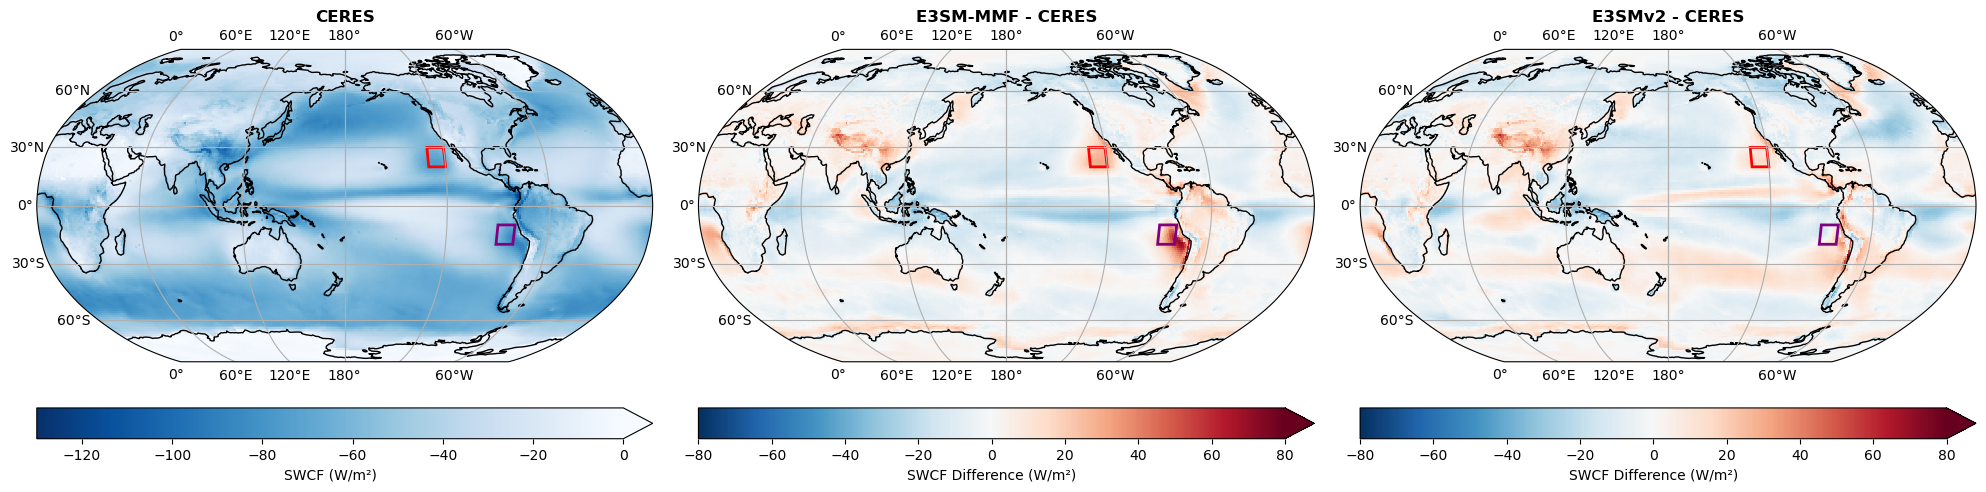

In [39]:
def plot_swcf_comparison(ceres_mean, mmf_radi_mean, e3sm_radi_mean):
    """
    Plot CERES SWCF and differences with E3SM-MMF and E3SMv2 in one row
    Shows only Californian and Peruvian stratocumulus regions
    """
    fig = plt.figure(figsize=(20, 5))
    
    # Create projection
    projection = ccrs.Robinson(central_longitude=180)
    
    # Create subplots in one row
    ax1 = plt.subplot(131, projection=projection)
    ax2 = plt.subplot(132, projection=projection)
    ax3 = plt.subplot(133, projection=projection)
    
    # Set up parameters
    vmin, vmax = -130, 0 # for CERES values
    diff_vmin, diff_vmax = -80, 80  # for differences
    
    # Plot CERES
    im1 = ceres_mean.plot(ax=ax1, transform=ccrs.PlateCarree(),
                                           cmap='Blues_r', vmin=vmin, vmax=vmax,
                                           add_colorbar=True,
                                           cbar_kwargs={'label': 'SWCF (W/m²)',
                                                      'orientation': 'horizontal',
                                                      'pad': 0.1})
    ax1.set_title('CERES', fontsize=12, pad=5, weight='bold')
    
    # Plot differences (using RdBu_r colormap)
    # E3SM-MMF - CERES
    diff_mmf = mmf_radi_mean - ceres_mean
    im2 = diff_mmf.plot(ax=ax2, transform=ccrs.PlateCarree(),
                       cmap='RdBu_r', vmin=diff_vmin, vmax=diff_vmax,
                       add_colorbar=True,
                       cbar_kwargs={'label': 'SWCF Difference (W/m²)',
                                  'orientation': 'horizontal',
                                  'pad': 0.1})
    ax2.set_title('E3SM-MMF - CERES', fontsize=12, pad=5, weight='bold')
    
    # E3SMv2 - CERES
    diff_e3sm = e3sm_radi_mean - ceres_mean
    im3 = diff_e3sm.plot(ax=ax3, transform=ccrs.PlateCarree(),
                        cmap='RdBu_r', vmin=diff_vmin, vmax=diff_vmax,
                        add_colorbar=True,
                        cbar_kwargs={'label': 'SWCF Difference (W/m²)',
                                   'orientation': 'horizontal',
                                   'pad': 0.1})
    ax3.set_title('E3SMv2 - CERES', fontsize=12, pad=5, weight='bold')
    
    # Selected regions to show
    selected_regions = ['Californian', 'Peruvian']
    
    # Add features to all subplots
    for ax in [ax1, ax2, ax3]:
        ax.coastlines()
        ax.gridlines(draw_labels=True)
        
        # Add boxes only for Californian and Peruvian regions
        for region_name in selected_regions:
            region_info = regions[region_name]
            lon_min, lon_max, lat_min, lat_max = region_info['coords']
            box = mpatches.Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min,
                                   fill=False, edgecolor=region_info['color'], linewidth=2,
                                   transform=ccrs.PlateCarree())
            ax.add_patch(box)
    
    plt.tight_layout()
    
    return fig


# Create plot
fig = plot_swcf_comparison(ceres_mean, mmf_radi_mean, e3sm_radi_mean)
plt.show()